# FINAL PROJECT

## Scraping Google Play Applications

In order to scrape the Google Play, we need to have a unique string called "id". It is only found in the address bar of the application. For instance, the link for Facebook Lite application, is a string like this: https://play.google.com/store/apps/details?id=com.facebook.lite.

The segment after "id", is the unique id of the application, which we will need when scraping the web, in this case, com.facebook.lite.

The problem is, there is no easy way to get a list of all applications which are present on the Google Play, or obtain the id of them. The reason for that lies under Google's policy to limit the search result, or the applications shown in each category (at most 250). For instance, when you choose apps of a category, and you scroll down till the end, maximum number of results that Google Play shows you is 250.

However, for the purposes of this project, we obtained the ids and full information of all applications in the following categories:

1. Health and Fitness: Top Free
2. Health and Fitness: Top Paid
3. Medical: Top Free
4. Medical: Top Paid

A total of 544 applications were scraped, and all information of these applications were obtained.

Informations contain the following 45 itmes (minus comments, which will be explained separately):

- title
- description
- summary
- installs
- minInstalls
- score
- ratings
- reviews
- histogram of scores
- price
- free
- currency
- sale
- originalPrice
- saleText
- offersIAP
- inAppProductPrice
- size
- androidVersion
- androidVersionText
- developer
- developerId
- developerEmail
- developerWebsite
- developerAddress
- privacyPolicy
- developerInternalID
- genre
- genreId
- icon
- headerImage
- screenshots
- video
- videoImage
- contentRating
- contentRatingDescription
- adSupported
- containsAds
- released
- updated
- version
- recentChanges
- editorsChoice
- appId
- url

We will manually (mouse click) open the applications from each of the four categories to get the link and consequently the id of the application, and then using a python code, store the name and id of each application in a .xslx file, called App Names and IDs.

## Storing Scraped Data

The volume of scraped data is pretty big, and it is very difficult to handle them with ordinary data containers, i.e., lists and NumPy arrays. 

The other challenge was to hold the data permanently, for further use. Which means we don't want to lose the data as soon as the program stops. We want to have the data indefinietly.

To satisfy mentioned criteria, we will use a database, in this case **MongoDB**, which is a new-generation database and very consistent with Python language. To do this, I have used <a href="https://towardsdatascience.com/create-dataset-for-sentiment-analysis-by-scraping-google-play-app-reviews-using-python-ceaaa0e41c1">this source</a> .

Storing the data will be done in two steps:

1. We will scrape and store the mentioned 45 itmes for each of the 544 applications, 

2. For each application, we will scrape the reviews in a batch of 200 reviews, for a total of 50 batches. This means we will scrape a maximum of 200 * 50 = 10,000 reviews per applications, for the purposes of this project.

The reason for scraping in batches and not all in once is 1) to avoid Google's privacy restrtictions which bans applications from some point forward, and 2) to avoid overflowing the memory and crashing the application. 3) To maintain the time limit and the deadline of the project, since each batch takes around a minute or more.



In [ ]:
import openpyxl
# for scraping app info and reviews from Google Play
from google_play_scraper import app, Sort, reviews

from pymongo import MongoClient

# for keeping track of timing
import datetime as dt
from tzlocal import get_localzone

# for building in wait times
import random
import time

## Setting Up MongoDB Connections

In [ ]:
# Set up Mongo client
client = MongoClient(host='localhost', port=27017)

## Database for projectx`
app_proj_db = client['app_proj_db6']

## Set up new collection within project db for app info
info_collection = app_proj_db['info_collection']

## Set up new collection within project db for app reviews
review_collection = app_proj_db['review_collection']

### Getting App IDs and Names

In [ ]:
# load excel with its path
wrkbk = openpyxl.load_workbook("App Names and IDs.xlsx")
sh = wrkbk.active

# iterate through excel and get app ids
app_ids = []
for row in sh.iter_rows(min_row=2, min_col=2, max_row=sh.max_row, max_col=2):
# for row in sh.iter_rows(min_row=2, min_col=2, max_row=10, max_col=2):
    for cell in row:
        app_ids.append(cell.value)

# iterate through excel and get app names
app_names = []
for row in sh.iter_rows(min_row=2, min_col=1, max_row=sh.max_row, max_col=1):
# for row in sh.iter_rows(min_row=2, min_col=1, max_row=10, max_col=1):
    for cell in row:
        app_names.append(cell.value)

### Scraping and Storing App Info (45 items)

In [ ]:
## Loop through app IDs to get app info
app_info = []
for i in app_ids:
    print("full info of", i, " is scraped")
    info = app(i)
    del info['comments']
    app_info.append(info)

## Pretty print the data for the first app
# pprint(app_info[0])

## Insert app details into info_collection
info_collection.insert_many(app_info)

### Scraping and Storing Comments

In [ ]:
## Loop through apps to get reviews
for app_name, app_id in zip(app_names, app_ids):

    # Get start time
    start = dt.datetime.now(tz=get_localzone())
    fmt = "%m/%d/%y - %T %p"

    # Print starting output for app
    # print('---' * 20)
    # print('---' * 20)
    print(f'***** {app_name} started at {start.strftime(fmt)}')
    print()

    # Empty list for storing reviews
    app_reviews = []

    # Number of reviews to scrape per batch
    count = 200

    # To keep track of how many batches have been completed
    batch_num = 0

    # Retrieve reviews (and continuation_token) with reviews function
    rvws, token = reviews(
        app_id,  # found in app's url
        lang='en',  # defaults to 'en'
        country='us',  # defaults to 'us'
        sort=Sort.MOST_RELEVANT,  # start with most recent
        count=count  # batch size
    )

    # For each review obtained
    for r in rvws:
        r['app_name'] = app_name  # add key for app's name
        r['app_id'] = app_id  # add key for app's id

    # Add the list of review dicts to overall list
    app_reviews.extend(rvws)

    # Increase batch count by one
    batch_num += 1
    print(f'Batch {batch_num} completed.')

    # Wait 1 to 5 seconds to start next batch
    time.sleep(random.randint(5, 20))

    # Append review IDs to list prior to starting next batch
    pre_review_ids = []
    for rvw in app_reviews:
        pre_review_ids.append(rvw['reviewId'])

    # Loop through at most max number of batches
    # for batch in range(4999):
    for batch in range(49):
        rvws, token = reviews(  # store continuation_token
            app_id,
            lang='en',
            country='us',
            sort=Sort.NEWEST,
            count=count,
            # using token obtained from previous batch
            continuation_token=token
        )

        # Append unique review IDs from current batch to new list
        new_review_ids = []
        for r in rvws:
            new_review_ids.append(r['reviewId'])

            # And add keys for name and id to ea review dict
            r['app_name'] = app_name  # add key for app's name
            r['app_id'] = app_id  # add key for app's id

        # Add the list of review dicts to main app_reviews list
        app_reviews.extend(rvws)

        # Increase batch count by one
        batch_num += 1

        # Break loop and stop scraping for current app if most recent batch
        # did not add any unique reviews
        all_review_ids = pre_review_ids + new_review_ids
        if len(set(pre_review_ids)) == len(set(all_review_ids)):
            print(f'No reviews left to scrape. Completed {batch_num} batches.\n')
            break

        # all_review_ids becomes pre_review_ids to check against
        # for next batch
        pre_review_ids = all_review_ids

        # At every 100th batch
        if batch_num % 100 == 0:
            # print update on number of batches
            print(f'Batch {batch_num} completed.')

            # insert reviews into collection
            review_collection.insert_many(app_reviews)

            # print update about num reviews inserted
            store_time = dt.datetime.now(tz=get_localzone())
            print(f"""
            Successfully inserted {len(app_reviews)} {app_name} 
            reviews into collection at {store_time.strftime(fmt)}.\n
            """)

            # empty our list for next round of 100 batches
            app_reviews = []

        # Wait 1 to 5 seconds to start next batch
        time.sleep(random.randint(5, 15))

    # Print update when max number of batches has been reached
    # OR when last batch didn't add any unique reviews
    print(f'Done scraping {app_name}.')
    print(f'Scraped a total of {len(set(pre_review_ids))} unique reviews.\n')

    if len(app_reviews) > 0:
    # Insert remaining reviews into collection
        review_collection.insert_many(app_reviews)

    # Get end time
    end = dt.datetime.now(tz=get_localzone())

    # Print ending output for app
    print(f"""
    Successfully inserted all {app_name} reviews into collection
    at {end.strftime(fmt)}.\n
    """)
    print(f'Time elapsed for {app_name}: {end - start}')
    print('---' * 20)
    print('---' * 20)
    print('\n')

    # Wait 1 to 5 seconds to start scraping next app
    time.sleep(random.randint(5, 10))

## Sentiment Analysis of the Comments

In order to analyze the comments, we need to read them from the database first, and since our model is set up in a way that it works with .csv files in two columns: 

First) the sentiment (one of 13 sentiment: 'empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise', 'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'), and 

Second) Content, which is basically a comment,

we need to first query the database and for each applicaiton, and load the data into a .csv file, in which there are two columns: sentiment and content, and each row represents a comment for the application, and the sentiment for the comment which is empty at first (before we predict it based on our trained model)

Here, we will query the data from the database to 544 .csv files, which will result in 544 files (each corresponding to one application), and 2000 comments (at most) of the application:

### Sentiment Analysis of the Comments: Readable Files

In [5]:
import pandas as pd
from pymongo import MongoClient
import json

path = "C:\\Users\\Sardar\\Desktop\\UCI\\Education\\3. Spring 2021 Q\\1. NLP\\4. Project\\1. Phase 1\\Comments and Apps\\"

## Set up Mongo client
client = MongoClient(host='localhost', port=27017)
db = client['app_proj_db5']
collection = db['review_collection']
print("Connection to Database Successful!")

# Get Applications' ids from database
app_ids = collection.distinct('app_id')


AppNumber = 0

for app_id in app_ids:
    print("App " + str(AppNumber) + " Started")
    reviewsList = []
    reviews = collection.find({"app_id": app_id}, {"_id": 0, "content": 1}).limit(2000)

    for review in reviews:
        review_json = json.dumps(review)
        review = json.loads(review_json)
        reviewsList.append(review["content"])

    content = reviewsList
    sentiment = [None] * len(content)

    data = {'sentiment': sentiment,
            'content': content
            }

    df = pd.DataFrame(data, columns=['sentiment', 'content'])
    df.to_csv(path + "Comments_App" + str(AppNumber) + " - " + app_id + ".csv", index=False, header=True)
    print("App " + str(AppNumber) + " Finished")
    AppNumber += 1
    print("---------------------------------------------------")
    
print("********* All Done! *********")  

Connection to Database Successful!
App 0 Started
App 0 Finished
---------------------------------------------------
App 1 Started
App 1 Finished
---------------------------------------------------
App 2 Started
App 2 Finished
---------------------------------------------------
App 3 Started
App 3 Finished
---------------------------------------------------
App 4 Started
App 4 Finished
---------------------------------------------------
App 5 Started
App 5 Finished
---------------------------------------------------
App 6 Started
App 6 Finished
---------------------------------------------------
App 7 Started
App 7 Finished
---------------------------------------------------
App 8 Started
App 8 Finished
---------------------------------------------------
App 9 Started
App 9 Finished
---------------------------------------------------
App 10 Started
App 10 Finished
---------------------------------------------------
App 11 Started
App 11 Finished
-----------------------------------------

### Sentiment Analysis of the Comments: Emotion Prediction

After preparing the comments files, we can now perform our sentiment analysis. 

Based on the provided emotions.csv files which we used in class, which contains 30,000 comments and labeled emotions on it, we will train our model, and then we will perform the prediction on the comments of all the applications, using our model.


In [6]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from os import listdir
from os.path import isfile, join
from sklearn.tree import DecisionTreeClassifier

print("Application Started!")

# Read Train Data
df_emotions = pd.read_csv(
    "C:\\Users\\Sardar\\Desktop\\UCI\\Education\\3. Spring 2021 Q\\1. NLP\\1. Lectures\\6. 5.12.2021\\emotions.csv")
train = df_emotions

print("Train File Reading Done")

# Used Vectorizer
vectorizer = CountVectorizer(ngram_range=(1, 1))
vectorizer.fit(train.content)

model = DecisionTreeClassifier()
model.fit(vectorizer.transform(train.content), train.sentiment)

print("Training the Model Done")
print("----------------------------------------")


mypath = "C:\\Users\\Sardar\\Desktop\\UCI\\Education\\3. Spring 2021 Q\\1. NLP\\4. Project\\1. Phase 1\\Comments and Apps\\"
fileNames = [f for f in listdir(mypath) if isfile(join(mypath, f))]

# Remove Blank lines
correctedPath = "C:\\Users\\Sardar\\Desktop\\UCI\\Education\\3. Spring 2021 Q\\1. NLP\\4. Project\\1. Phase 1\\Comments and Apps Corrected\\"

print("Verifying CSV files...")

for fileName in fileNames:
    data = pd.read_csv(mypath + fileName, skip_blank_lines=True)
    data.dropna(how="all", inplace=True)
    data.to_csv(correctedPath + fileName, index=False, header=True)

print("Verification Done")
print("--------------------------------")

# Make Predictions
i = 0
for fileName in fileNames:
    print("App " + str(i) + " Started")
    test = pd.read_csv("C:\\Users\\Sardar\\Desktop\\UCI\\Education\\3. Spring 2021 Q\\1. NLP\\4. Project\\1. Phase 1\\Comments and Apps Corrected\\" + fileName)

    prediction = model.predict(vectorizer.transform(test.content))
    print("App " + str(i) + " Prediction Done")

    data = {'sentiment': prediction, 'content': test["content"]}

    df = pd.DataFrame(data, columns=['sentiment', 'content'])
    savepath = "C:\\Users\\Sardar\\Desktop\\UCI\\Education\\3. Spring 2021 Q\\1. NLP\\4. Project\\1. Phase 1\\Labeled Comments\\"
    df.to_csv(savepath + fileName, index=False, header=True)
    print("App " + str(i) + " Done")
    i += 1
    print("----------------------------------------")
    
print("********* All Done! *********")    

Application Started!
Train File Reading Done
Training the Model Done
----------------------------------------
Verifying CSV files...
Verification Done
--------------------------------
App 0 Started
App 0 Prediction Done
App 0 Done
----------------------------------------
App 1 Started
App 1 Prediction Done
App 1 Done
----------------------------------------
App 2 Started
App 2 Prediction Done
App 2 Done
----------------------------------------
App 3 Started
App 3 Prediction Done
App 3 Done
----------------------------------------
App 4 Started
App 4 Prediction Done
App 4 Done
----------------------------------------
App 5 Started
App 5 Prediction Done
App 5 Done
----------------------------------------
App 6 Started
App 6 Prediction Done
App 6 Done
----------------------------------------
App 7 Started
App 7 Prediction Done
App 7 Done
----------------------------------------
App 8 Started
App 8 Prediction Done
App 8 Done
----------------------------------------
App 9 Started
App 9 Pred

We now have 544 .csv files, each containing at most 2000 comments of the associated application, and for each comment, we have the sentiment prediction.

## Analysis of the Results

For each application, we can perform numerous analysis. For instance, we can see the overall performance of the application in the eyes of the comments, with the following plot:

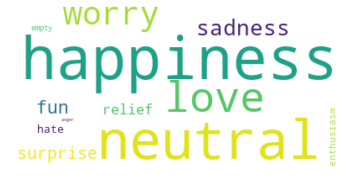

In [45]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

sentiments = ""
for data in test['sentiment']:
    sentiments = sentiments + " " + data

# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(sentiments)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<AxesSubplot:>

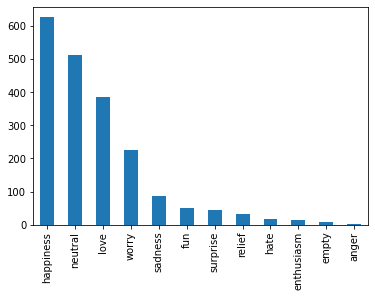

In [15]:
df_emotions = pd.read_csv(
    "C:\\Users\\Sardar\\Desktop\\UCI\\Education\\3. Spring 2021 Q\\1. NLP\\1. Lectures\\6. 5.12.2021\\emotions.csv")
train = df_emotions

test = test = pd.read_csv("C:\\Users\\Sardar\\Desktop\\UCI\\Education\\3. Spring 2021 Q\\1. NLP\\4. Project\\1. Phase 1\\Labeled Comments\\Comments_App20 - buttocksworkout.hipsworkouts.forwomen.legworkout.csv")

test['sentiment'].value_counts().plot(kind='bar')

In [16]:
def plot_confusion_matrix(preds, labels):
  class_labels = np.unique(df_emotions.sentiment)
  class_size = len(class_labels)
  cnf_mat = confusion_matrix(labels, preds, class_labels)                            #Computes confusion_matrix
  cnf_mat = cnf_mat.astype('float') / (cnf_mat.sum(axis=1)[:, np.newaxis]+1)
  plt.imshow(cnf_mat, interpolation='nearest', cmap=plt.cm.Blues)
  #plt.xticks(np.arange(class_size), np.arange(1, class_size + 1), class_labels)
  plt.xticks(np.arange(class_size), labels=class_labels, rotation='vertical')
  plt.yticks(np.arange(class_size), labels=class_labels)
  #plt.yticks(np.arange(class_size), np.arange(1, class_size + 1), class_labels)
  plt.title('Confusion matrix of the classifier')
  plt.xlabel('True Label')
  plt.ylabel('Predicted Label')
  plt.title('Confusion Matrix')
  plt.colorbar()
  plt.show()

In [19]:
from sklearn.metrics import confusion_matrix, precision_score, precision_recall_curve, recall_score, f1_score, accuracy_score

tv = CountVectorizer(ngram_range=(1,1))
tv.fit(train.content)

modelELR = DecisionTreeClassifier()
modelELR.fit(tv.transform(train.content), train.sentiment)
elr_pred = modelELR.predict(tv.transform(test.content))

print("Confusion Matrix:\n", confusion_matrix(test.sentiment, elr_pred))
print("F1 score:", f1_score(test.sentiment, elr_pred, average='micro'))

Confusion Matrix:
 [[  0   0   0   0   0   0   0   1   0   0   0   0]
 [  0   4   0   0   4   0   0   1   0   0   0   0]
 [  0   0   5   0   0   0   0   4   0   1   1   2]
 [  0   2   0  36   3   0   0   6   2   1   0   0]
 [  0   1   1   2 606   1   8   1   1   3   2   1]
 [  0   0   0   0   0   9   1   2   1   1   0   3]
 [  0   1   1   1  14   0 338  14   2   1   3  10]
 [  0   0   2   2  23   1   8 433   0   5  16  22]
 [  0   0   0   8   1   0   3   1  15   0   1   2]
 [  0   1   0   1   1   1   1   9   1  63   0   7]
 [  0   0   0   0   0   0   1   5   1   0  33   4]
 [  0   0   3   8   6   2   3  12   2   6   2 182]]
F1 score: 0.8619999999999999


C:\Users\Sardar\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['anger' 'boredom' 'empty' 'enthusiasm' 'fun' 'happiness' 'hate' 'love'
 'neutral' 'relief' 'sadness' 'surprise' 'worry'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


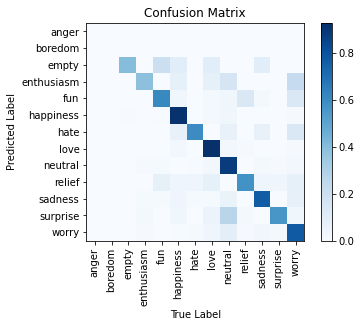

In [22]:
import numpy as np
import matplotlib.pyplot as plt

plot_confusion_matrix(test.sentiment, elr_pred)

## Summary

We gathered comprehensive data from the top free and paid applications in the two categories of Health and Fitness, and Medical. 

Also, we scraped top 10,000 comments (if available) for each of the applications, and stored them in MongoDB, for future use. 

We created a framework with which by having the id of each application (unique id given by Google Play to each app), you can perform sentiment analysis on the comments of the application.

Moreover, there are 45 itmes of scraped information for each app, which enables us for numerous analysis in the future.


## Final Discussion and Future Direction

There are indefinite number of possible analysis available to implement on this data, but considering the purpose of the project and time limitations, in this workbook we have performed only a sample analysis on a single data unit.

However, for the future analysis, we can compare any two applications and understand which one is better-received by  consumers. Also, we can perform further analysis which can help us get insights from comments.

Also, we can associate the rating which comes with each comment as an indicator of a sentiment, which will be a great help in ruling out outliers. For instance, if a review has a score of 5, we can rule out 'hate' from possible emotions, and put more weight on the possibility of having 'happiness' or 'love' emotion.

This project is a great starting point for any future research, which requires consumer insights from the Google Play apllication.



-------------------------    





This is a research project for the Natural Language Processing course, instructed by <a href="https://merage.uci.edu/research-faculty/faculty-directory/Vibhanshu-Abhishek.html">Professor Vibhanshu Abhishek(Vibs)</a> , at <a href="https://merage.uci.edu/index.html">Merage School of Business</a>, University of California, Irvine (UCI), by <a href="https://merage.uci.edu/programs/phd/student-directory.html">Sardar Fatooreh Bonabi</a>.